# Qiskit Runtime - Primitives and Sessions

## Primitives

Primitives are a set of interface with Qiskit Runtime to help users build complex algorithms based on the results they need.

The existing Qiskit interface to backends `backend.run()` was originally designed to accept a list of circuits and return counts for every job. However the raw results might not be useful for users, hence the need for primitives. They provide methods that make it easier to build modular algorithms and other higher-order programs. Rather than simply returning counts, they return more immediately meaningful information. Additionally, they provide a seamless way to access the latest optimizations in IBM Quantum hardware and software.

Two primitives are available :

- **Estimator** : 
    - Allows a user to specify a list of circuits and observables and selectively group between the lists to efficiently evaluate expectation values and variances for a parameter input. It is designed to enable users to efficiently calculate and interpret expectation values of quantum operators that are required for many algorithms. 
- **Sampler** :
    - Allows a user to input a circuit and then generate quasiprobabilities. This generation enables users to more efficiently evaluate the possibility of multiple relevant data points in the context of destructive interference.

In the following notebook we'll see how to use the primitives with Qiskit Runtime, and all the different options available for the run.

## How to use the primitives

### 1. Choose which primitive to use

As you can see on the [guide](https://qiskit.org/ecosystem/ibm-runtime/migrate/migrate-guide.html), you have different primitives implementations based on what you need.

- The primitives in `qiskit` can perform local state vector simulations - useful for quickly prototyping algorithms.
- The primitives in `qiskit_aer` give access to the local Aer simulators for tasks such as noisy simulation.
- The primitives in `qiskit_ibm_runtime` provide access to cloud simulators and real hardware through the Qiskit Runtime service. They include exclusive features such as built-in circuit optimization and error mitigation support.


Here we'll mainly focus on the Qiskit Runtime primitives. Note that they are the only ones that give you access to the Qiskit Runtime service.

You also have to choose from either the `Estimator` or the `Sampler`.
- If it uses an expectation value, you will need an `Estimator`.
- If it uses a probability distribution (from sampling the device), you will need a `Sampler`.



### 2. Initialize your account


In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel='ibm_quantum')

### 3. Load the backend

You can pass either one or the other when running the program, both will work.

In [2]:
sim_name = 'ibmq_qasm_simulator'
sim = service.backend(sim_name)

backend_name = 'ibm_perth'
backend = service.backend(backend_name)

### 4. Create your circuit

Here we'll work with one of the Bell states.

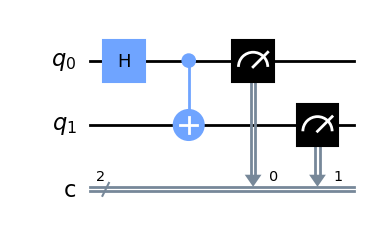

In [3]:
from qiskit import QuantumCircuit

circuit_bell = QuantumCircuit(2,2) # This creates a quantum circuit consisting of 2 qubits and 2 classical bits.

circuit_bell.h(0) # First we apply a Hadamard gate to q_0
circuit_bell.cx(0,1) # then we add a controlled-not gate with q_0 as the control and q_1 as the target.

circuit_bell.measure(0,0) # We then measure q_0 and store the result in the 0th classical bit
circuit_bell.measure(1,1) # We then measure q_1 and store the result in the 1st classical bit

circuit_bell.draw("mpl") # Draws the quantum circuit using matplotlib (mpl) library.

### 5. Load the Sampler Primitive

In [4]:
from qiskit_ibm_runtime import Sampler, Options

options = Options(max_execution_time = 300) # the Options are optional, but it is recommended to set a max_execution_time. Later in this notebook we will try out some Options that can help us improve the performance of our circuits. 
sampler = Sampler(backend = sim, options = options)

### 6. Invoke the primitive and get back results

In [5]:
job_sampler = sampler.run(circuit_bell, shots = 4000)
print(f"Job ID: {job_sampler.job_id()}") # Job ID is a unique identifier that can be used to retrieve an already run job at a later time
print(f"Job Status: {job_sampler.status()}") 

base_primitive._run_primitive:INFO:2023-11-20 10:34:01,156: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': 300, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Traceback (most recent call last):
  Cell In[5], line 1
    job_sampler = sampler.run(circuit_bell, shots = 4000)
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/sampler.py:122 in run
    return super().run(
  File /opt/conda/lib/python3.10/site-packages/qiskit/primitives/base/base_sampler.py:147 in run
    return self._run(
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/sampler.py:152 in _run
    return self._run_primitive(
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/base_primitive.py:209 in _run_primitive
    return self._service.run(
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:1009 in run
    raise IBMRuntimeError(f"Failed to run program: {ex}") from None
IBMRuntimeError: 'Failed to run program: "HTTPSConnectionPool(host=\'api.quantum-computing.ibm.com\', port=443): Max retries exceeded with url: /runtime/jobs (Caused by ResponseError(\'too many 500 error responses\'))"'

Use %

In [ ]:
result = job_sampler.result()
print(result)

We see that our result is output as a SamplerResult that contains both the quasi-distribution and the metadata. Not only that, the quasi_dist is showing us the probabilities of some integer values instead of binary values. We can separate the quasi_dist and the Metadata out of the SamplerResult, along with changing the integers to binary, by running the following code:

In [30]:
counts = result.quasi_dists[0].binary_probabilities()
print(f"Quasi-distribution: {counts}")
print(f"Metadata: {result.metadata[0]}")

Quasi-distribution: {'00': 0.5005, '11': 0.4995}
Metadata: {'shots': 4000, 'circuit_metadata': {}}


Now let's plot a histogram of our measurement results.

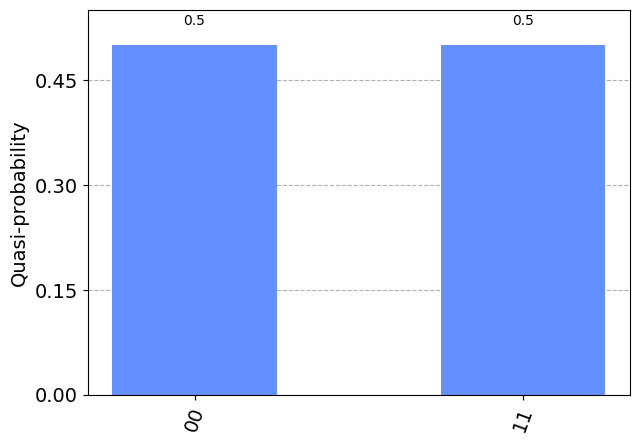

In [31]:
from qiskit.visualization import plot_distribution
plot_distribution(result.quasi_dists[0].binary_probabilities())

# Recitation

Let's now consolidate the things we learned above into a cleaner and more concisely written code to better see what we actually did.

In [32]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit

service = QiskitRuntimeService(channel='ibm_quantum')
sim_name = 'ibmq_qasm_simulator'
sim = service.backend(sim_name)
sampler = Sampler(backend = sim)

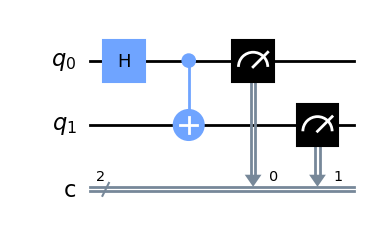

In [33]:
## Create a quantum circuit with 2 qubits and 2 classical bits 
qc_bell = QuantumCircuit(2,2)

## Prepare the Bell state
qc_bell.h(0)
qc_bell.cx(0,1)

# Measure both of the qubits and save it to the classical bits
qc_bell.measure(0,0)
qc_bell.measure(1,1)

# Draw the quantum circuit we have created
qc_bell.draw("mpl")

base_primitive._run_primitive:INFO:2023-11-19 14:56:32,184: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


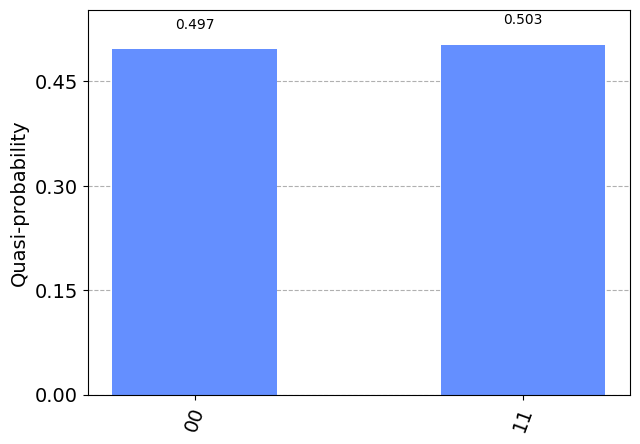

In [36]:
# Now we run the sampler with inputs: our quantum circuit, qc_bell, along with the desired number of shots.
job_sampler = sampler.run(qc_bell, shots = 4000)
result = job_sampler.result()

# print(result.quasi_dists[0].binary_probabilities())
plot_distribution(result.quasi_dists[0].binary_probabilities())

---

# Estimator Primitive

We will now try out the estimator primitive and see how we can use it to estimate expectation values by proving it with a quantum circuit and an observable.

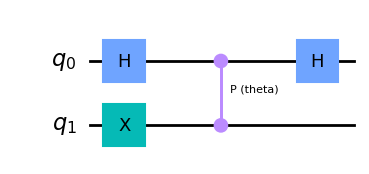

In [6]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

theta = Parameter('theta') # We can use the 'Parameter' function to define a dummy variable that we can assign a value at a later time.

circuit_est = QuantumCircuit(2)
circuit_est.x(1)
circuit_est.h(0)
circuit_est.cp(theta,0,1)
circuit_est.h(0)

circuit_est.draw('mpl')

Let's now create a list of values that we can substitute for the parameter 'theta'.

In [7]:
import numpy as np

phases = np.linspace(0, 2*np.pi, 50)
individual_phases = [[phase] for phase in phases] # phases need to be expressed as a list of lists in order to work

Now define an observable (a Hermitian/self-adjoint operator) to estimate the expectation value of. Such an observable could be the ZZ operator, that is the tensor product of two Pauli-Z matrices. 

In [8]:
from qiskit.quantum_info import SparsePauliOp 
observable = SparsePauliOp("ZZ")
print(f">>> Observable: {observable.paulis}")

>>> Observable: ['ZZ']


In [9]:
from qiskit_ibm_runtime import Estimator, Options
options = Options(max_execution_time = 300)
estimator = Estimator(backend = sim, options = options)

In [10]:
job_est = estimator.run(
        circuits = [circuit_est]*len(phases),
        parameter_values = individual_phases,
        observables = [observable]*len(phases))
print(f"Job ID: {job_est.job_id()}")
print(f"Job Status: {job_est.status()}")

base_primitive._run_primitive:INFO:2023-11-20 10:35:34,820: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': 300, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Traceback (most recent call last):
  Cell In[10], line 1
    job_est = estimator.run(
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/estimator.py:147 in run
    return super().run(
  File /opt/conda/lib/python3.10/site-packages/qiskit/primitives/base/base_estimator.py:188 in run
    return self._run(
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/estimator.py:185 in _run
    return self._run_primitive(
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/base_primitive.py:209 in _run_primitive
    return self._service.run(
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:1009 in run
    raise IBMRuntimeError(f"Failed to run program: {ex}") from None
IBMRuntimeError: 'Failed to run program: "HTTPSConnectionPool(host=\'api.quantum-computing.ibm.com\', port=443): Max retries exceeded with url: /runtime/jobs (Caused by ResponseError(\'too many 500 error responses\'))"'

Use %tb to get the full tra

In [11]:
result = job_est.result()
print(result)

Traceback (most recent call last):
  Cell In[11], line 1
    result = job_est.result()
NameError: name 'job_est' is not defined

Use %tb to get the full traceback.


In [12]:
print(f"Expectation value: {result.values}")
print(f"Metadata: {result.metadata}")

Traceback (most recent call last):
  Cell In[12], line 1
    print(f"Expectation value: {result.values}")
NameError: name 'result' is not defined

Use %tb to get the full traceback.


In [13]:
import matplotlib.pyplot as plt
plt.plot(phases, result.values, 'o')

Traceback (most recent call last):
  Cell In[13], line 2
    plt.plot(phases, result.values, 'o')
NameError: name 'result' is not defined

Use %tb to get the full traceback.


# Transpiling a quantum circuit to fit with the backend



Let's now assume we wanted to run our circuit on a real device for example the ibm_perth backend. In order to run a quantum circuit on a backend the circuit must be constructed in a way that is compatible with the underlying hardware. We therefore have to make considerations as to the kinds of gates the circuit consists of, the connectivity of the qubits in the device, and if we want to ensure the best quality of our experiments we should also take the error rates of particular qubits into account. As we will see in just a moment, we are fortunately not required to make these considerations ourselves, instead we can simply let Qiskit's transpiler function take care of this. But let's investigate the problem a little anyway and see what kind of items we can uncover.

#### We can start by figuring out what kind of gates the backend supports, this can be done by the following:

In [14]:
backend.operations

[Instruction(name='id', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='rz', num_qubits=1, num_clbits=0, params=[Parameter(λ)]),
 Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='x', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]),
 Instruction(name='reset', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]),
 Delay(duration=t[unit=dt])]

We see that the supported operations of the backend are: identity, Z-rotations, square root of X gate, X gate, Controlled-X gate, reset, and measurement. So we better make sure that our quantum circuits are built using these gates.

#### Now let's take look at the qubit layout and the error rates of the device:

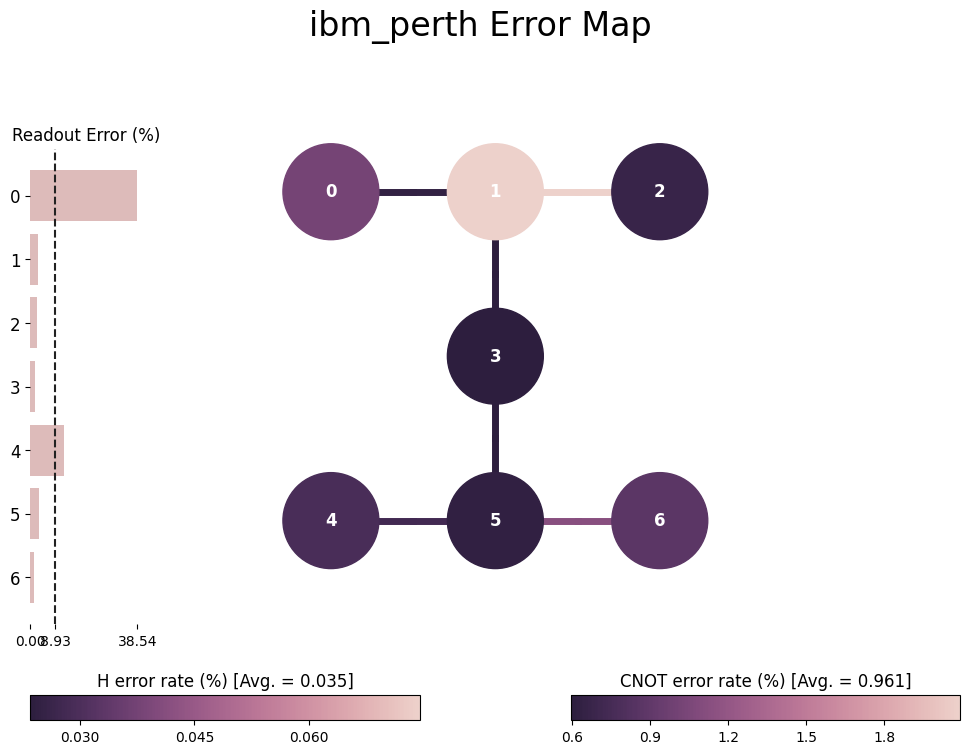

In [15]:
from qiskit.visualization import plot_error_map
plot_error_map(backend)

#### Let's now construct the quantum circuit we used for the estimator once again:

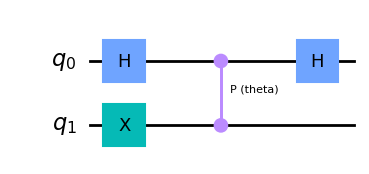

In [16]:
circuit_est = QuantumCircuit(2)
circuit_est.x(1)
circuit_est.h(0)
circuit_est.cp(theta,0,1)
circuit_est.h(0)

circuit_est.draw('mpl')

#### We see that it uses gates that are not supported by the backend, and we must therefore use the transpiler function to convert the quantum circuit into something the backend will support. This is very simple to do, and it can be done in just a single line of code modulo a library import.

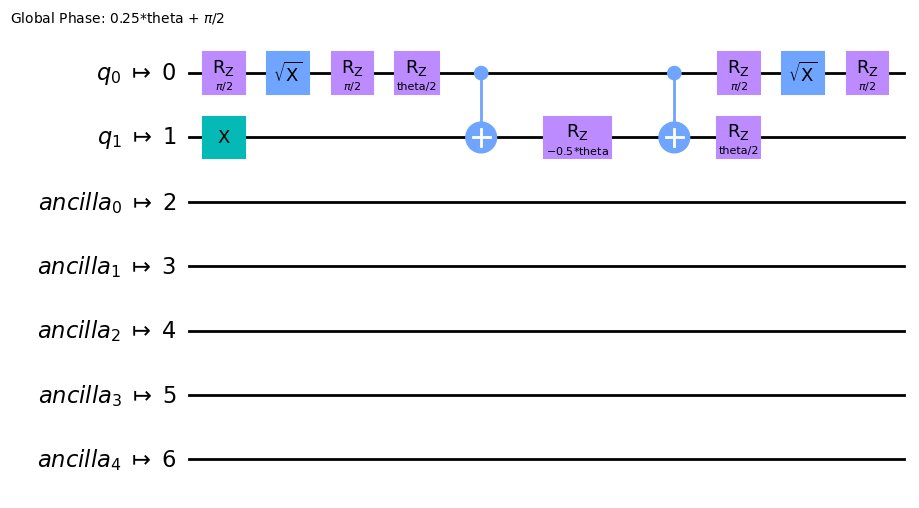

In [17]:
from qiskit import transpile
transpiled_circuit = transpile(circuits = circuit_est, backend = backend)
transpiled_circuit.draw('mpl')

There are several options for the transpiler, one of the most useful options is the optimization_level, which seek to find more optimal circuit configurations that will yield better results, taking into account things like number of gates, error rates of gates on specific qubits, etc. 

Changing the optimization level determines how much optimization to perform on the circuits. Higher levels generate more optimized circuits, at the expense of longer transpilation time.

0: no optimization

1: light optimization

2: heavy optimization

3: even heavier optimization

If None, level 1 will be chosen as default.

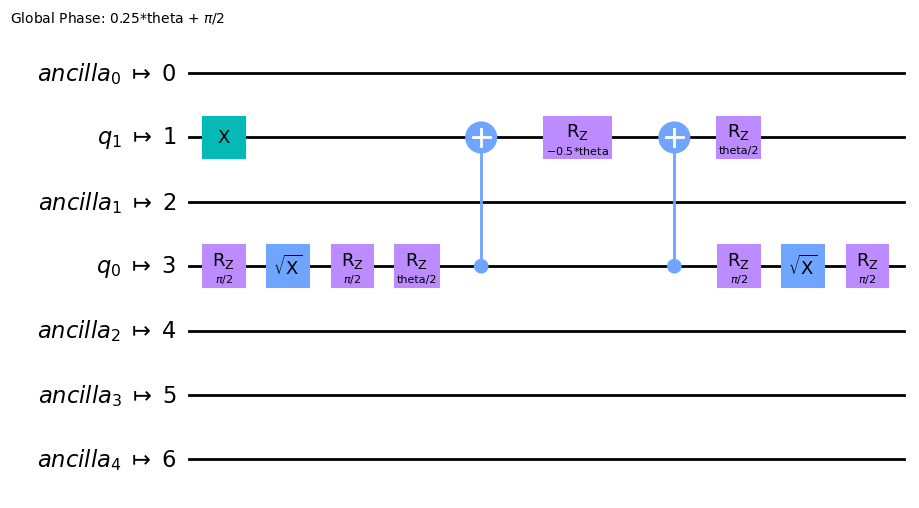

In [18]:
transpiled_circuit_lvl_3 = transpile(circuits = circuit_est, backend = backend, optimization_level = 3)
transpiled_circuit_lvl_3.draw('mpl')

We see that picking a higher optimization_level for the transpiler in this case didn't change the depth of the circuit, but instead it simply decided to use different qubits instead. The reasoning behind this choice can be inferred from looking at the error map, where it is seen that the one- and two-qubit error rates are significantly lower between the qubits 1 and 3.